In [1]:
import tensorflow as tf
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN, Dropout, GaussianNoise
from keras.optimizers import Adam, SGD
from keras.utils import to_categorical 
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, LabelBinarizer, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, silhouette_score, adjusted_rand_score
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

Using TensorFlow backend.


In [2]:
#read the dataset with artificial categories
df = pd.read_excel('Colorectal Generated Data_New.xlsx')
df.set_index('Name',inplace=True)

In [3]:
#extract inputs and outputs
df_outputs= df['Marker']
df_inputs=df.drop(['Marker'],axis=1)

In [4]:
df_inputs=df_inputs.select_dtypes(np.number)
df_inputs=df_inputs.to_numpy()

In [5]:
def process_attributes(df, train, test):
    cs = MinMaxScaler()
    trainContinuous = cs.fit_transform(train.select_dtypes(np.number).head())
    testContinuous = cs.transform(test.select_dtypes(np.number).head())
    trainX = trainContinuous
    testX = testContinuous
    # return the concatenated training and testing data
    return (trainX, testX)

In [6]:
label_encoder = LabelEncoder()

true_labels = label_encoder.fit_transform(df_outputs)

true_labels

array([0, 0, 0, ..., 1, 1, 1], dtype=int64)

In [7]:
df_inputs#n_clusters = len(label_encoder.classes_)

array([[0.14      , 0.51333333, 0.39333333, ..., 0.17      , 1.48      ,
        1.79666667],
       [0.07005291, 0.69819349, 0.27842026, ..., 0.23495086, 1.12526835,
        2.12142099],
       [0.20994709, 0.32847318, 0.5082464 , ..., 0.10504914, 1.83473165,
        1.47191234],
       ...,
       [0.24957568, 0.5672319 , 0.72190697, ..., 0.06867817, 1.63710791,
        1.78184563],
       [0.16970988, 0.78309076, 0.18981615, ..., 0.13256664, 1.34451282,
        2.11591703],
       [0.53708374, 0.35336507, 0.54185766, ..., 0.25748459, 2.12170987,
        1.46415999]])

In [8]:
preprocessor = Pipeline(
    [
        ("scaler", MinMaxScaler()),
        ("pca", PCA(n_components=2)),
    ]
)

In [9]:
clusterer = Pipeline(
    [
        (
            "kmeans",
            KMeans(
                n_clusters=2,
                init="k-means++",
                n_init=50,
                max_iter=500
            ),
        ),
    ]
)

In [10]:
pipe = Pipeline(
    [
        ("preprocessor",preprocessor),
        ("clusterer",clusterer),
    ]

)

In [11]:
pipe.fit(df_inputs)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('scaler', MinMaxScaler()),
                                 ('pca', PCA(n_components=2))])),
                ('clusterer',
                 Pipeline(steps=[('kmeans',
                                  KMeans(max_iter=500, n_clusters=2,
                                         n_init=50))]))])

In [12]:
preprocessed_data = pipe["preprocessor"].transform(df_inputs)
predicted_labels = pipe["clusterer"]["kmeans"].labels_

In [13]:
silhouette_score(preprocessed_data, predicted_labels)

0.3407239649207753

In [14]:
adjusted_rand_score(true_labels, predicted_labels)

0.31230145610622423

In [15]:
pcadf = pd.DataFrame(
    pipe["preprocessor"].transform(df_inputs),
    columns=["component_1", "component_2"])

In [16]:
pcadf["predicted_cluster"] = pipe["clusterer"]["kmeans"].labels_
pcadf["true_label"] = label_encoder.inverse_transform(true_labels)

C:\Users\Alext\anaconda3\envs\RP\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


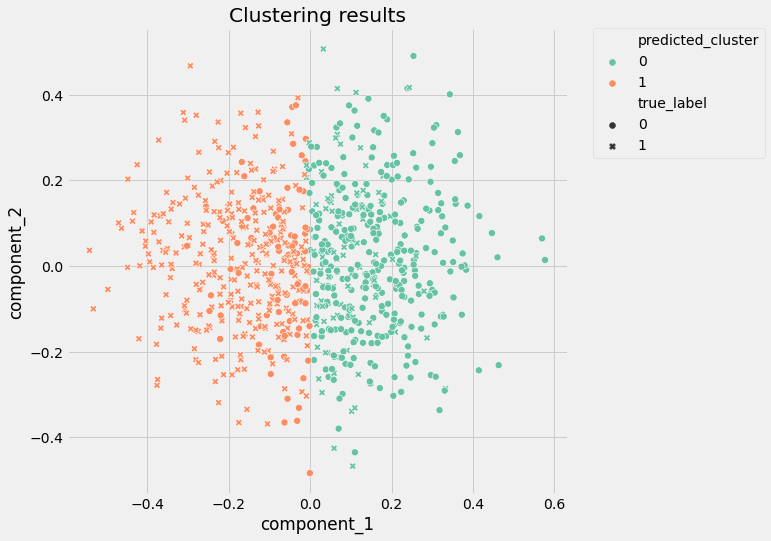

In [17]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(8, 8))

scat = sns.scatterplot(
    "component_1",
    "component_2",
    s=50,
    data=pcadf.sample(n=800),
    hue="predicted_cluster",
    style="true_label",
    palette="Set2",
)

scat.set_title(
    "Clustering results"
)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

plt.show()

In [18]:
predicted_labels

array([0, 0, 0, ..., 1, 0, 1])

In [19]:
pcadf

,component_1,component_2,predicted_cluster,true_label
0,0.116771,0.003017,0,0
1,0.140062,-0.089555,0,0
2,0.093481,0.095589,0,0
3,0.125131,-0.152065,0,0
4,0.167934,0.311977,0,0
...,...,...,...,...
2041,-0.262039,-0.059085,1,1
2042,-0.152916,-0.138576,1,1
2043,-0.177188,-0.094065,1,1
2044,0.105926,0.097431,0,1
